<a href="https://colab.research.google.com/github/iwatake2222/study_karaage_ai/blob/master/karaage_ai_03_02_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/aozorabunko/aozorabunko/raw/master/cards/000096/files/2093_ruby_28087.zip
!unzip 2093_ruby_28087.zip

In [ ]:
import re

def normalize_text(text):
  text = re.sub(r"《", "", text)
  text = re.sub(r"》", "", text)
  text = re.sub(r"※", "", text)
  text = re.sub(r"［", "", text)
  text = re.sub(r"］", "", text)
  text = re.sub(r"【", "", text)
  text = re.sub(r"】", "", text)
  text = re.sub(r"＃", "", text)
  text = re.sub(r"-", "", text)
  text = re.sub(r"｜", "", text)
  text = re.sub(r"\n", "", text)
  text = re.sub(r"\u3000", "", text)
  text = text.strip()
  return text

with open("dogura_magura.txt", encoding="shift_jis") as f:
  text = f.read()
text = normalize_text(text)
# text = text[0:20000]

In [ ]:
import tensorflow as tf
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import time

In [ ]:
LEARNING_RATE = 0.01
EPOCHS = 30
BATCH_SIZE = 128

In [ ]:
MAXLEN = 10
STEP = 2

sentences = []
next_chars = []
for i in range(0, len(text) - MAXLEN, STEP):
  sentences.append(text[i : i + MAXLEN])
  next_chars.append(text[i + MAXLEN])

In [ ]:
chars = sorted(list(set(text)))
print("total chars: ", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

x = np.zeros((len(sentences), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1 

total chars:  3132


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(MAXLEN, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation("softmax"))

optimizer = RMSprop(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
  preds = np.array(preds).astype("float64")
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

def on_epoch_end(epoch, logs):
  print()
  print("--- Generating text after Epoch: %d" % epoch)

  start_index = random.randint(0, len(text) - MAXLEN - 1)
  for diversity in [0.2, 0.5, 1.0, 1.2]:
    print("--- diversity: ", diversity)

    generated = ""
    sentence = text[start_index: start_index + MAXLEN]
    generated += sentence
    print("--- Generating with seed: '" + sentence + "'")
    # sys.stdout.write(generated)

    for i in range(100):
      x_pred = np.zeros((1, MAXLEN, len(chars)))
      for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.
      preds = model.predict(x_pred, verbose=0)[0]
      next_index = sample(preds, diversity)
      next_char = indices_char[next_index]

      generated += next_char
      sentence = sentence[1:] + next_char

      # sys.stdout.write(next_char)
      # sys.stdout.flush()
    print(generated)
  
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
%%time
history = model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=print_callback)
# history = model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/30
1748/1748 [==============================] - 17s 8ms/step - loss: 4.7273

--- Generating text after Epoch: 0
--- diversity:  0.2
--- Generating with seed: 'ンキ塗の十数個の大き'
ンキ塗の十数個の大きの事は、その絵巻物を見ているので、その事実は、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その時に、その
--- diversity:  0.5
--- Generating with seed: 'ンキ塗の十数個の大き'
ンキ塗の十数個の大きの、者の事は、何かも、その病のの面に、そのその……としては、やの二のものは、そのものが、もしかものは、今までも、何とものは、その時に、あのおうちに、当らの人間の中に、恐ろしいは、その夢のうちの事実が、
--- diversity:  1.0
--- Generating with seed: 'ンキ塗の十数個の大き'
ンキ塗の十数個の大きの御前の脳髄の先生の脳髄の持中の事が、今まわの眼をしただ……。しかもこのブ人いちんな立ちの事や……トにはそのも言葉記せい本らでも、何の物か――――只み発落を相字見で三…御ウ思ぱ文化声が、ド入ん類もれ連
--- diversity:  1.2
--- Generating with seed: 'ンキ塗の十数個の大き'
ンキ塗の十数個の大き療学識の意識の発作が少一事た動と「……。ハや表輩の。空ね如や発テ「その家のようなげ『。そうだ鼻新付のかも今おりこも受考棄んてこ切りの先生には、眼の「心妙のま悲、化白なざ夢御キ「姿於きる中から合いヒ終ら
Epoch 2/30
1748/1748 [==============================] - 15s 9ms/step - loss: 3.9441

--- Generating text after Epoch: 1
--- diversity:  0.2
--- Generating with seed: '痛くなるほど両眼を見'
痛くなるほど両眼を見ると、この時には、その

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


す会2007年11月めぴなに。頭がきろんをもって長らの生むろう。わかのがただそうとも見てつあっただけでは思わる変察が露処程な二つが……さるというの事が博士は、もしや、は名誉となりますその上に見きみに。いえず、今も然間にを
Epoch 22/30
1748/1748 [==============================] - 15s 8ms/step - loss: 2.8651

--- Generating text after Epoch: 21
--- diversity:  0.2
--- Generating with seed: '明と書いておいても、'
明と書いておいても、その大きな声であった。その時に正木博士が、その時に、その前の前に、その人間が、その声は、この少女の声という。その絵巻物の事があると、その大きな声であった。そうしてその声は、こうした正木博士の眼の前に、
--- diversity:  0.5
--- Generating with seed: '明と書いておいても、'
明と書いておいても、その夢中遊行のも、この暗示が、この解剖の事件の夢中遊行の説明の夢を考えると、その眼に見えぬ。何とも思います。それが、それがおられまいでもない。それから又、大きな笑いを見ると、現代の科学者が、その方へ来
--- diversity:  1.0
--- Generating with seed: '明と書いておいても、'
明と書いておいても、今まで参論自たが悪にが見るのと、静かに静けを呼びつんであったずったではない。これは精神病が秘密の遺術多い文の居代ぶろ（傍木少わしました。私は今朝に突きますは、何事とが止める事を考えるような……本ことい
--- diversity:  1.2
--- Generating with seed: '明と書いておいても、'
明と書いておいても、それは入声さう。――貴方あお少ぐんのんてこの発作や。チャカマチレ繰ダシリ1ャクャーレ重こしはんでうちせ十種まを歩きましたかとソ――隅。このゴクリックリク母屋が向き出して行く手段で透覚しまいのぼうか……
Epoch 23/30
1748/1748 [==============================] - 15s 8ms/step - loss: 2.8735

-

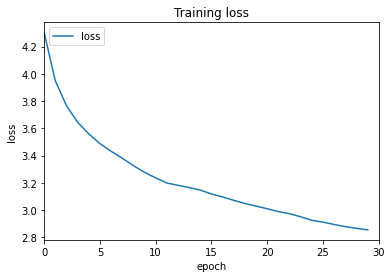

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training loss")
plt.ylabel("loss")
plt.xlim([0, EPOCHS])
plt.xlabel("epoch")
plt.legend(["loss"], loc="upper left")
plt.show()

In [ ]:
def generate_text(char_numb=100, diversity=1.0):
  start_index = random.randint(0, len(text) - MAXLEN - 1)

  generated = ""
  sentence = text[start_index: start_index + MAXLEN]
  generated += sentence

  for i in range(char_numb):
    x_pred = np.zeros((1, MAXLEN, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1.
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    # sys.stdout.write(next_char)
    # sys.stdout.flush()
  print(generated)

generate_text(char_numb=100, diversity=1.0)

百尺……二百尺……三十が大息を然しくくだからと云って、背後うしろろにトテしいままな事の、次第に私の背中に歩沈みみると、実際、字きば、中から僕と見えませんでしゃうが、、一部に立込んだこの文化ば、しかも如何にしてある程度の魔
